# CTD profiles

In [1]:
import os
import gsw
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as AA

from mpl_toolkits.axes_grid1 import host_subplot
from ctd import DataFrame, Series, lp_filter, movingaverage


def derive_cnv(self):
    """Compute SP, SA, CT, z, and GP from a cnv pre-processed cast."""
    cast = self.copy()  # FIXME: Use MetaDataFrame to propagate lon, lat.
    p = cast.index.values.astype(float)
    cast['SP'] = gsw.SP_from_C(cast['c0S/m'] * 10., cast['t090C'], p)
    cast['SA'] = gsw.SA_from_SP(cast['SP'], p, self.lon, self.lat)
    cast['SR'] = gsw.SR_from_SP(cast['SP'])
    cast['CT'] = gsw.CT_from_t(cast['SA'], cast['t090C'], p)
    cast['z'] = -gsw.z_from_p(p, self.lat)
    cast['SG'] = gsw.sigma0_CT_exact(cast['SA'], cast['CT'])
    return cast


def proc_ctd(fname, compression='gzip', below_water=True):
    # 00-Split, clean 'bad pump' data, and apply flag.
    cast = DataFrame.from_cnv(fname, compression=compression,
                              below_water=below_water).split()[0]
    cast = cast[cast['pumps']]
    cast = cast[~cast['flag']]  # True for bad values.
    name = os.path.basename(fname).split('.')[0]

    # Removed unwanted columns.
    keep = set(['c0S/m', 'dz/dtM', 'latitude', 'longitude', 'sbeox0Mm/Kg',
                't090C'])

    null = map(cast.pop, keep.symmetric_difference(cast.columns))
    del null

    # Smooth velocity with a 2 seconds windows.
    cast['dz/dtM'] = movingaverage(cast['dz/dtM'], window_size=48)

    # 01-Filter pressure.
    kw = dict(sample_rate=24.0, time_constant=0.15)
    cast.index = lp_filter(cast.index, **kw)

    # 02-Remove pressure reversals.
    cast = cast.press_check()
    cast = cast.dropna()

    # 03-Loop Edit.
    cast = cast[cast['dz/dtM'] >= 0.25]  # Threshold velocity.

    # 04-Remove spikes.
    kw = dict(n1=2, n2=20, block=100)
    cast = cast.apply(Series.despike, **kw)

    # 05-Bin-average.
    cast = cast.apply(Series.bindata, **dict(delta=1.))

    # 06-interpolate.
    cast = cast.apply(Series.interpolate)

    if True:  # 07-Smooth.
        pmax = max(cast.index)
        if pmax >= 500.:
            window_len = 21
        elif pmax >= 100.:
            window_len = 11
        else:
            window_len = 5
        kw = dict(window_len=window_len, window='hanning')
        cast = cast.apply(Series.smooth, **kw)

    # Add metadata to the DataFrame.
    cast.lat = cast['latitude'].mean()
    cast.lon = cast['longitude'].mean()
    cast.name = name

    # 08-Derive.
    cast = derive_cnv(cast)
    return cast


def plot_vars(self, figsize=(6, 8)):
    """Plot CTD temperature, salinity, and density."""
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(bottom=0.1, top=0.85)
    ax0 = host_subplot(111, axes_class=AA.Axes)
    ax0.invert_yaxis()

    ax1, ax2 = ax0.twiny(), ax0.twiny()

    new_axis0 = ax0.get_grid_helper().new_fixed_axis
    new_axis1 = ax1.get_grid_helper().new_fixed_axis
    new_axis2 = ax2.get_grid_helper().new_fixed_axis

    ax0.axis["bottom"] = new_axis0(loc="bottom", axes=ax0, offset=(0, 0))
    ax1.axis["bottom"] = new_axis1(loc="bottom", axes=ax1, offset=(0, -40))
    ax2.axis["top"] = new_axis2(loc="top", axes=ax2, offset=(0, 0))

    ax0.axis["top"].toggle(all=False)
    ax1.axis["top"].toggle(all=False)
    ax2.axis["bottom"].toggle(all=False)

    ax0.set_ylabel('Pressure')
    ax0.set_xlabel(r'$\sigma_{\theta}$ [kg m$^{-3}$]')
    ax1.set_xlabel(r'Reference Salinity [g kg$^{-1}$]')
    ax2.set_xlabel(u'Conservative Temperature [\xb0C]')

    l0, = ax0.plot(self['SG'], self.index)
    l1, = ax1.plot(self['SA'], self.index)
    l2, = ax2.plot(self['CT'], self.index)

    ax0.axis["bottom"].label.set_color(l0.get_color())
    ax1.axis["bottom"].label.set_color(l1.get_color())
    ax2.axis["top"].label.set_color(l2.get_color())

    fig.subplots_adjust(bottom=0.15, top=0.95)

    return fig, (ax0, ax1, ax2), (l0, l1, l2)

In [2]:
cast = proc_ctd(
    'data/CTD.cnv.bz2',
    compression='bz2',
    below_water=True
)

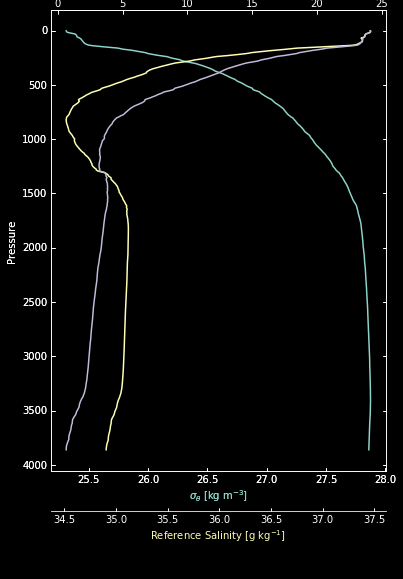

In [3]:
%matplotlib inline
from matplotlib import style

style.use('dark_background')


fig, ax, l = plot_vars(cast)